# Importy, wizualizacja
(Należy odpalić i schować).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Subset
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, Lambda, ToTensor

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"

def plot_dataset(train_data, generator, is_cond=False, n_samples = 5, show_train=True):
    view_data = train_data.data[:n_samples].view(-1, 28 * 28) / 255.0

    if show_train:
        labels = train_data.targets[:n_samples]
    else:
        labels = torch.arange(n_samples) % 10

    noise = torch.randn((n_samples, generator.latent_dim), device=device)
    with torch.no_grad():
        if is_cond:
            labels_one_hot = torch.nn.functional.one_hot(labels, 10).to(torch.float32).to(device)
            gen_data = generator(noise, labels_one_hot).cpu().detach().numpy()
        else:
            gen_data = generator(noise).cpu().detach().numpy()

    n_rows = 2 if show_train else 1
    n_cols = len(view_data)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    if show_train:
        for i in range(n_cols):
            axes[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap="gray")
            axes[0][i].set_xticks(())
            axes[0][i].set_yticks(())

        for i in range(n_cols):
            axes[1][i].clear()
            axes[1][i].imshow(np.reshape(gen_data[i], (28, 28)), cmap="gray")
            axes[1][i].set_xticks(())
            axes[1][i].set_yticks(())

    else:
        for i in range(n_cols):
            axes[i].imshow(np.reshape(gen_data[i], (28, 28)), cmap="gray")
            axes[i].set_xticks(())
            axes[i].set_yticks(())

    plt.show()

torch.manual_seed(1337)
batch_size = 128
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

# Mnist dataset
train_data = FashionMNIST(
    root=".", train=True, transform=transforms, download=True
)  # change to false if you already have the data

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 9527208.72it/s] 


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 196895.79it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3657112.82it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17963624.79it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



# Generative Adversarial Networks (GANs)

Idea GANów polega na takim ustaleniu wag generatora, aby utworzone przykłady były nieodróżnialne od prawdziwych danych (pochodziły z tego samego rozkładu). Nowatorskie podejście w GANach polega na tym, że model oceniający czy dane są realistyczne, będzie się uczył razem z modelem generującym. Powyższa idea oznacza to, że model GANowski jest grą dwóch graczy:

* pierwszym graczem jest generator $G(z)$ reprezentowany przez sieć neuronową z parametrami $\theta$ zaś $z$ ∼ $N(0, I)$ jest losowym szumem z rozkładu normalnego. Jego głównym zadaniem jest przekształcenie szumu wejściowego $z$ w obiekt $G(z)$ ∼ $P_G$ podobny do rzeczywistych danych (z rozkładu $P_{dane}$).
* drugim graczem jest dyskryminator $D(x)$ reprezentowany przez sieć neuronową z parametrami $\phi$, zaś $x$ jest obiektem z $P_G$ albo $P_{dane}$. Dyskryminator ma odróżniać dane pochodzące od generatora od danych rzeczywistych. Mówiąc dokładniej jest to klasyfikator, który zwraca prawdopodobieństwo, że obiekt $x$ pochodzi z danych rzeczywistych $P_{dane}$, a nie z $P_G$.

<img src="resources/gan.png">

Architecture of a generative adversarial network. ([Image source](http://www.kdnuggets.com/2017/01/generative-adversarial-networks-hot-topic-machine-learning.html))

## Zadanie 1. Vanilla GAN (3 pkt.)

Należy zaimplementować klasy Generator i Discriminator. Można zastosować dowolną architekturę sieci pod warunkiem, że:
* Generator przyjmuje wektor o rozmiarze `latent_dim` i produkuje wektor o rozmiarze `out_dim` z wartościami w zakresie \[-1, 1\]. Przykladową implementacją są warstwy nn.Linear \[latent_dim, 128, 256, 512, out_dim] z aktywacjami nn.LeakyReLU oraz nn.Tanh na końcu.
* Discriminator przyjmuje wektor o rozmiarze `input_size` i produkuje wektor o rozmiarze `1` z wartościami w zakresie \[0, 1\]. Przykladową implementacją są warstwy nn.Linear \[input_size, 128, 128, 64, 1] z aktywacjami nn.LeakyReLU oraz nn.Sigmoid na końcu.

In [5]:
class Generator(torch.nn.Module):

    def __init__(self, latent_dim: int, out_dim: int):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.out_dim = out_dim

        self.model = nn.Sequential(
            nn.Linear(self.latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, self.out_dim),
            nn.Tanh(),
        )


    def forward(self, x):
        return self.model(x)

In [6]:
class Discriminator(nn.Module):

    def __init__(self, input_size: int):
        super(Discriminator, self).__init__()
        self.input_size = input_size

        self.model = nn.Sequential(
            nn.Linear(self.input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

Epoch: 0  |  total loss: 1.2603 |  disc_loss: 0.9203 | gen_loss: 1.6003


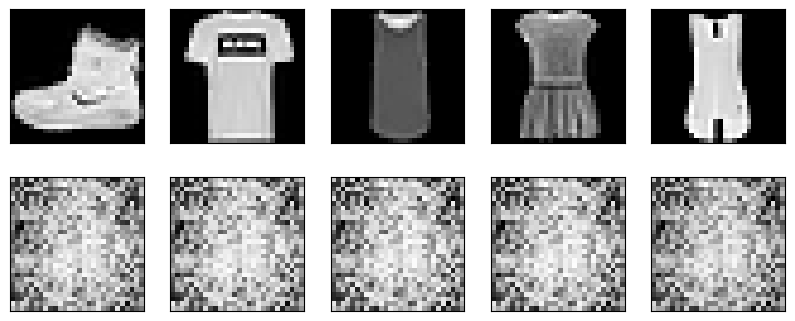

Epoch: 1  |  total loss: 1.4728 |  disc_loss: 0.4994 | gen_loss: 2.4462
Epoch: 2  |  total loss: 1.2715 |  disc_loss: 0.5289 | gen_loss: 2.0141
Epoch: 3  |  total loss: 1.5379 |  disc_loss: 0.6921 | gen_loss: 2.3836
Epoch: 4  |  total loss: 1.4447 |  disc_loss: 0.7166 | gen_loss: 2.1728
Epoch: 5  |  total loss: 1.5987 |  disc_loss: 0.7511 | gen_loss: 2.4463


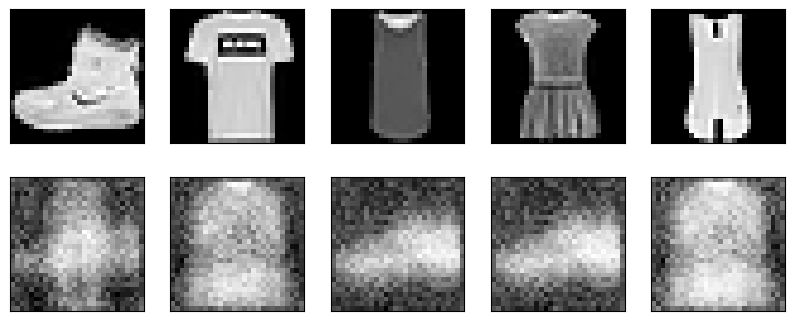

Epoch: 6  |  total loss: 1.4383 |  disc_loss: 0.5844 | gen_loss: 2.2921
Epoch: 7  |  total loss: 1.8898 |  disc_loss: 0.5496 | gen_loss: 3.2300
Epoch: 8  |  total loss: 1.5117 |  disc_loss: 0.6282 | gen_loss: 2.3952
Epoch: 9  |  total loss: 1.7075 |  disc_loss: 0.5801 | gen_loss: 2.8350
Epoch: 10  |  total loss: 1.6039 |  disc_loss: 0.4879 | gen_loss: 2.7200


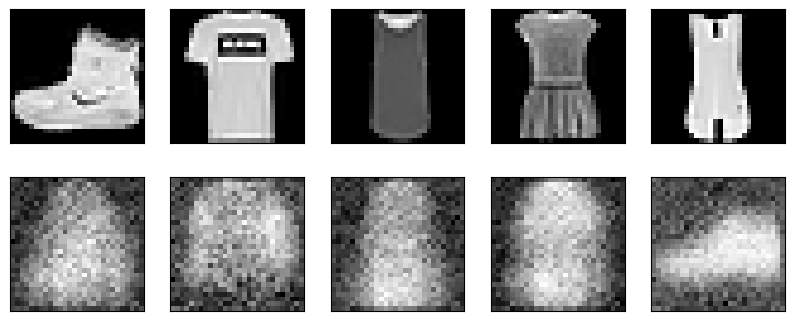

Epoch: 11  |  total loss: 1.6393 |  disc_loss: 0.6107 | gen_loss: 2.6678
Epoch: 12  |  total loss: 1.7256 |  disc_loss: 0.5223 | gen_loss: 2.9290
Epoch: 13  |  total loss: 1.5755 |  disc_loss: 0.6068 | gen_loss: 2.5442
Epoch: 14  |  total loss: 1.9326 |  disc_loss: 0.6137 | gen_loss: 3.2514
Epoch: 15  |  total loss: 1.5929 |  disc_loss: 0.6245 | gen_loss: 2.5613


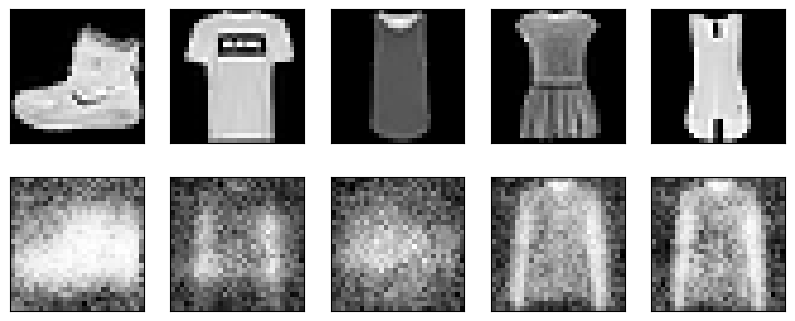

Epoch: 16  |  total loss: 1.7330 |  disc_loss: 0.6969 | gen_loss: 2.7692
Epoch: 17  |  total loss: 1.5413 |  disc_loss: 0.6460 | gen_loss: 2.4366
Epoch: 18  |  total loss: 1.5525 |  disc_loss: 0.6549 | gen_loss: 2.4502
Epoch: 19  |  total loss: 1.5691 |  disc_loss: 0.6088 | gen_loss: 2.5295
Epoch: 20  |  total loss: 1.4851 |  disc_loss: 0.6518 | gen_loss: 2.3184


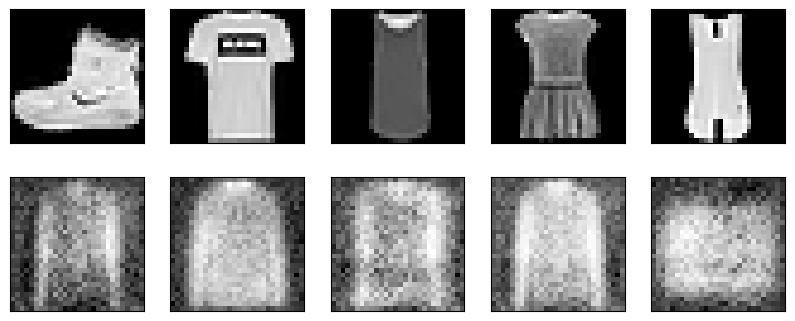

Epoch: 21  |  total loss: 1.5940 |  disc_loss: 0.6961 | gen_loss: 2.4919
Epoch: 22  |  total loss: 1.4826 |  disc_loss: 0.6746 | gen_loss: 2.2907
Epoch: 23  |  total loss: 1.5928 |  disc_loss: 0.6860 | gen_loss: 2.4997
Epoch: 24  |  total loss: 1.5381 |  disc_loss: 0.6624 | gen_loss: 2.4137


In [7]:
# Hyper Parameters
epochs: int = 25
g_lr: float = 1e-4  # learning rate
d_lr: float = 1e-4
latent_dim = 64

# models
generator = Generator(latent_dim, 784).to(device)
discriminator = Discriminator(784).to(device)

# optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=g_lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=d_lr)

criterion = nn.BCELoss()

for epoch in range(epochs):
    epoch_losses = []  # For logging purposes
    for step, (x, _) in enumerate(train_loader):
        real_x = x.to(device)

        batch_size = real_x.shape[0]

        # Train discriminator
        d_optimizer.zero_grad()

        real_d_pred = discriminator(real_x)
        real_discriminator_loss = criterion(real_d_pred, torch.ones((batch_size, 1), device=device))

        noise = torch.randn((batch_size, latent_dim), device=device)
        fake_x = generator(noise)
        fake_d_pred = discriminator(fake_x.detach())
        fake_discriminator_loss = criterion(fake_d_pred, torch.zeros((batch_size, 1), device=device))

        discriminator_loss = real_discriminator_loss + fake_discriminator_loss
        discriminator_loss.backward()
        d_optimizer.step()

        # Train generator
        g_optimizer.zero_grad()

        noise = torch.randn((batch_size, latent_dim), device=device)
        gen_x = generator(noise)
        gen_d_pred = discriminator(gen_x)
        generator_loss = criterion(gen_d_pred, torch.ones((batch_size, 1), device=device))
        generator_loss.backward()
        g_optimizer.step()

        epoch_losses.append(np.array([discriminator_loss.item(), generator_loss.item()]))

    epoch_losses_np = np.stack(epoch_losses, axis=0)

    print(f"Epoch: {epoch}  |  total loss: {epoch_losses_np.mean():.4f} |  disc_loss: {epoch_losses_np[:, 0].mean():.4f} | gen_loss: {epoch_losses_np[:, 1].mean():.4f}")

    if epoch % 5 == 0:
        plot_dataset(train_data, generator)

## Zadanie 2. Conditional GAN (4 pkt.)

Zwykły GAN generuje obraz z szumu i trudno nam kontrolować wynik. Możemy wymusić GAN generować obrazki z wybranej klasy podając do sieci wektor, który ją enkoduje.

<img src="resources/cgan.png">

CGAN vs GAN diagram ([Image source](https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/))

Należy zaimplementować klasy ConditionalGenerator i ConditionalDiscriminator. Można zastosować dowolną architekturę sieci pod warunkiem, że:
* Generator przyjmuje wektory o rozmiarach `latent_dim` i `num_classes` oraz produkuje wektor o rozmiarze `out_dim` z wartościami w zakresie \[-1, 1\]. Przykladową implementacją są warstwy nn.Linear \[latent_dim + num_classes, 128, 256, 512, out_dim] z aktywacjami nn.LeakyReLU oraz nn.Tanh na końcu.
* Discriminator przyjmuje wektory o rozmiarach `latent_dim` i `num_classes` oraz produkuje wektor o rozmiarze `1` z wartościami w zakresie \[0, 1\]. Przykladową implementacją są warstwy nn.Linear \[input_size + num_classes, 128, 128, 64, 1] z aktywacjami nn.LeakyReLU oraz nn.Sigmoid na końcu.

In [8]:
class ConditionalGenerator(torch.nn.Module):

    def __init__(self, latent_dim: int, out_dim: int, num_classes: int):
        super(ConditionalGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.out_dim = out_dim
        self.num_classes = num_classes

        self.model = nn.Sequential(
            nn.Linear(self.latent_dim + self.num_classes, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, self.out_dim),
            nn.Tanh(),
        )

    def forward(self, x, one_hot_label):
        x = torch.cat((x, one_hot_label), dim=1)  # może być zmienione
        return self.model(x)

In [9]:
class ConditionalDiscriminator(nn.Module):

    def __init__(self, input_size: int, num_classes:int):
        super(ConditionalDiscriminator, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes

        self.model = nn.Sequential(
            nn.Linear(self.input_size + self.num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, one_hot_label):
        x = torch.cat((x, one_hot_label), dim=1) # może być zmienione
        return self.model(x)

Epoch: 0  |  total loss: 1.2630 |  disc_loss: 0.8537 | gen_loss: 1.6722


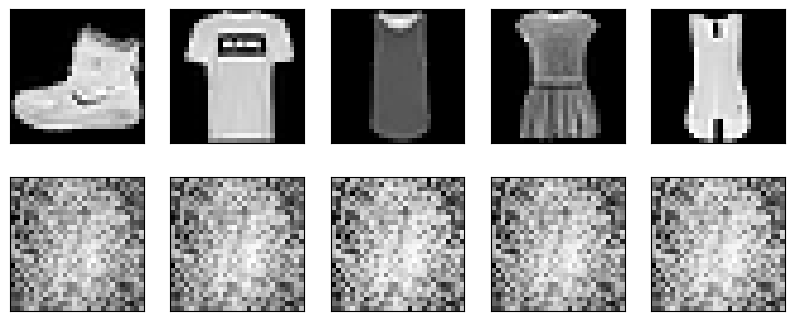

Epoch: 1  |  total loss: 1.3771 |  disc_loss: 0.4821 | gen_loss: 2.2722
Epoch: 2  |  total loss: 1.3975 |  disc_loss: 0.4070 | gen_loss: 2.3880
Epoch: 3  |  total loss: 1.6509 |  disc_loss: 0.6624 | gen_loss: 2.6395
Epoch: 4  |  total loss: 1.7200 |  disc_loss: 0.5523 | gen_loss: 2.8876
Epoch: 5  |  total loss: 1.8423 |  disc_loss: 0.5213 | gen_loss: 3.1633


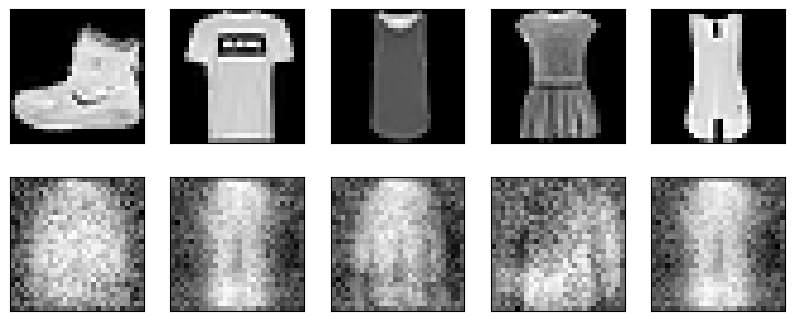

Epoch: 6  |  total loss: 1.7310 |  disc_loss: 0.5515 | gen_loss: 2.9106
Epoch: 7  |  total loss: 1.8404 |  disc_loss: 0.5598 | gen_loss: 3.1210
Epoch: 8  |  total loss: 1.7823 |  disc_loss: 0.4769 | gen_loss: 3.0877
Epoch: 9  |  total loss: 1.7638 |  disc_loss: 0.5166 | gen_loss: 3.0109
Epoch: 10  |  total loss: 1.8174 |  disc_loss: 0.5052 | gen_loss: 3.1296


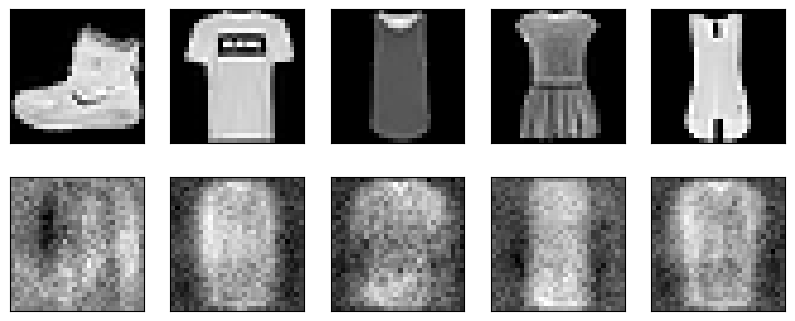

Epoch: 11  |  total loss: 1.5890 |  disc_loss: 0.5820 | gen_loss: 2.5959
Epoch: 12  |  total loss: 1.6696 |  disc_loss: 0.6245 | gen_loss: 2.7147
Epoch: 13  |  total loss: 1.5894 |  disc_loss: 0.5868 | gen_loss: 2.5919
Epoch: 14  |  total loss: 1.6349 |  disc_loss: 0.6700 | gen_loss: 2.5998
Epoch: 15  |  total loss: 1.6029 |  disc_loss: 0.7059 | gen_loss: 2.4998


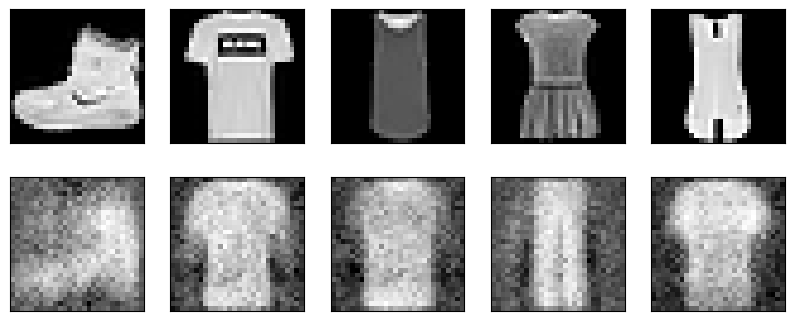

Epoch: 16  |  total loss: 1.4986 |  disc_loss: 0.7779 | gen_loss: 2.2192
Epoch: 17  |  total loss: 1.5525 |  disc_loss: 0.8259 | gen_loss: 2.2790
Epoch: 18  |  total loss: 1.5030 |  disc_loss: 0.7166 | gen_loss: 2.2894
Epoch: 19  |  total loss: 1.5886 |  disc_loss: 0.7767 | gen_loss: 2.4005
Epoch: 20  |  total loss: 1.4786 |  disc_loss: 0.7481 | gen_loss: 2.2092


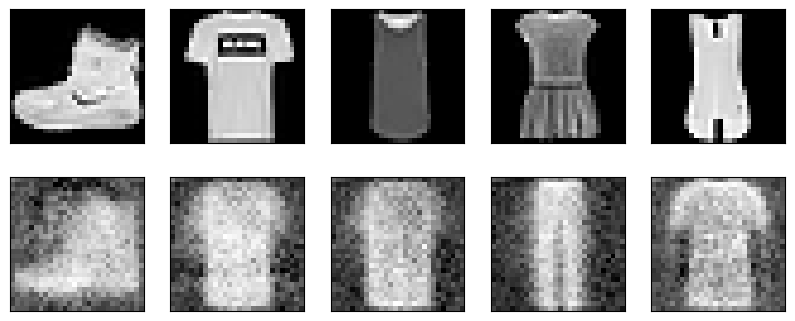

Epoch: 21  |  total loss: 1.5119 |  disc_loss: 0.7615 | gen_loss: 2.2622
Epoch: 22  |  total loss: 1.4759 |  disc_loss: 0.7583 | gen_loss: 2.1936
Epoch: 23  |  total loss: 1.5777 |  disc_loss: 0.7818 | gen_loss: 2.3737
Epoch: 24  |  total loss: 1.4715 |  disc_loss: 0.7377 | gen_loss: 2.2054


In [10]:
# Hyper Parameters
epochs: int = 25
g_lr: float = 1e-4
d_lr: float = 1e-4
latent_dim = 64

# models
generator = ConditionalGenerator(latent_dim, 784, 10).to(device)
discriminator = ConditionalDiscriminator(784, 10).to(device)

# optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=g_lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=d_lr)

criterion = nn.BCELoss()

for epoch in range(epochs):
    epoch_losses = []  # For logging purposes
    for step, (x, y) in enumerate(train_loader):
        real_x= x.to(device)
        y_one_hot = torch.nn.functional.one_hot(y, 10).to(torch.float32).to(device)
        batch_size = real_x.shape[0]

        # Train discriminator
        d_optimizer.zero_grad()

        real_d_pred = discriminator(real_x, y_one_hot)
        real_discriminator_loss  = criterion(real_d_pred, torch.ones((batch_size, 1), device=device))

        noise = torch.randn((batch_size, latent_dim), device=device)
        fake_x = generator(noise, y_one_hot)
        fake_d_pred = discriminator(fake_x.detach(), y_one_hot)
        fake_discriminator_loss = criterion(fake_d_pred, torch.zeros((batch_size, 1), device=device))

        discriminator_loss = real_discriminator_loss + fake_discriminator_loss
        discriminator_loss.backward()
        d_optimizer.step()

        # Train generator
        g_optimizer.zero_grad()

        noise = torch.randn((batch_size, latent_dim), device=device)
        gen_x = generator(noise, y_one_hot)
        gen_d_pred = discriminator(gen_x, y_one_hot)
        generator_loss = criterion(gen_d_pred, torch.ones((batch_size, 1), device=device))
        generator_loss.backward()
        g_optimizer.step()

        epoch_losses.append(np.array([discriminator_loss.item(), generator_loss.item()]))

    epoch_losses_np = np.stack(epoch_losses, axis=0)

    print(f"Epoch: {epoch}  |  total loss: {epoch_losses_np.mean():.4f} |  disc_loss: {epoch_losses_np[:, 0].mean():.4f} | gen_loss: {epoch_losses_np[:, 1].mean():.4f}")

    if epoch % 5 == 0:
        plot_dataset(train_data, generator, is_cond=True)

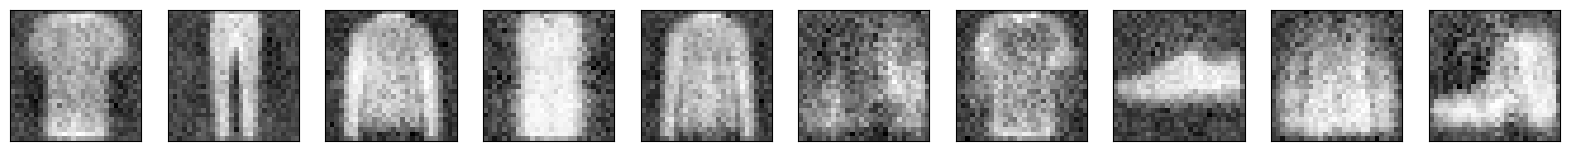

In [11]:
plot_dataset(train_data, generator, is_cond=True, n_samples=10, show_train=False)  # generuje wszystkie klasy